In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir Dataset

In [ ]:
!kaggle datasets download -d hmchuong/xray-bone-shadow-supression

100% 5.22G/5.23G [02:43<00:00, 41.0MB/s]
100% 5.23G/5.23G [02:44<00:00, 34.2MB/s]


In [ ]:
!unzip "/content/xray-bone-shadow-supression.zip" -d "/content/Dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/augmented/augmented/source/8_136.png  
  inflating: /content/Dataset/augmented/augmented/source/8_137.png  
  inflating: /content/Dataset/augmented/augmented/source/8_138.png  
  inflating: /content/Dataset/augmented/augmented/source/8_139.png  
  inflating: /content/Dataset/augmented/augmented/source/8_14.png  
  inflating: /content/Dataset/augmented/augmented/source/8_140.png  
  inflating: /content/Dataset/augmented/augmented/source/8_141.png  
  inflating: /content/Dataset/augmented/augmented/source/8_142.png  
  inflating: /content/Dataset/augmented/augmented/source/8_143.png  
  inflating: /content/Dataset/augmented/augmented/source/8_144.png  
  inflating: /content/Dataset/augmented/augmented/source/8_145.png  
  inflating: /content/Dataset/augmented/augmented/source/8_146.png  
  inflating: /content/Dataset/augmented/augmented/source/8_147.png  
  inflating: /content/Dataset/augmented/augmented/sou

In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 131 µs (started: 2022-06-10 08:43:13 +00:00)


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras.layers import BatchNormalization
from keras.models import Model

import tensorflow as tf
# from keras.optimizers import RMSprop

time: 3.06 ms (started: 2022-06-10 09:07:46 +00:00)


In [ ]:
def load_data(no_of_images):
    
    img_size = (256,256)
    imgs_source = []
    imgs_target = []
    
    dir_source = "/content/Dataset/augmented/augmented/source"
    dir_target = "/content/Dataset/augmented/augmented/target"
    
    i = 0
    for _, _, filenames in os.walk('/content/Dataset/augmented/augmented/source'):
        for filename in filenames:
            i = i+1
            if(i > no_of_images):
                break
            img_source = cv2.imread(os.path.join(dir_source,filename),cv2.IMREAD_GRAYSCALE)
            img_target = cv2.imread(os.path.join(dir_target, filename),cv2.IMREAD_GRAYSCALE)
            # resizing images
            img_source = cv2.resize(img_source,img_size)
            img_target = cv2.resize(img_target,img_size)
            # normalizing images
            img_source = np.array(img_source)/255
            img_target = np.array(img_target)/255
            
            imgs_source.append(img_source)
            imgs_target.append(img_target)
    return imgs_source, imgs_target

time: 17.9 ms (started: 2022-06-10 09:07:47 +00:00)


In [ ]:
source, target = load_data(1000)

time: 24 s (started: 2022-06-10 09:07:47 +00:00)


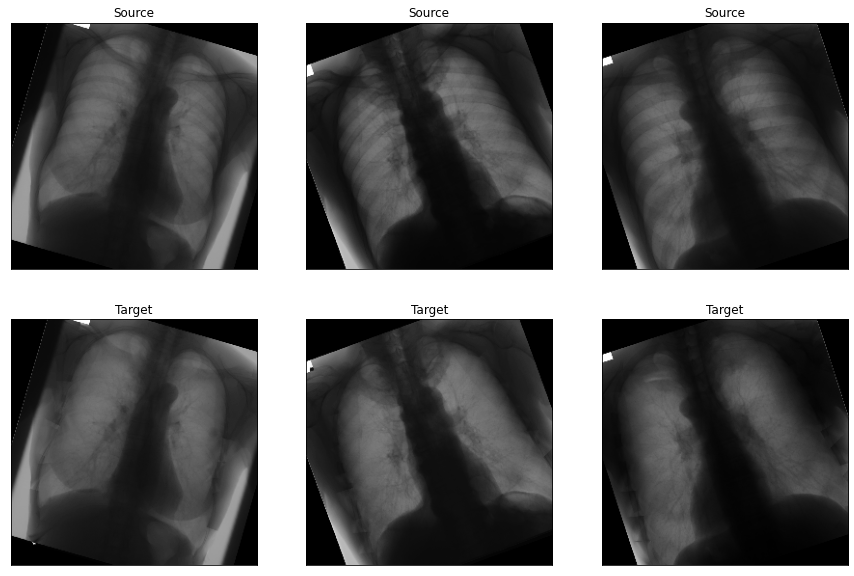

time: 457 ms (started: 2022-06-10 09:08:11 +00:00)


In [ ]:
plt.figure(figsize=(15,10))

for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(source[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source')

    ax = plt.subplot(2, 3, i+4)
    plt.imshow(target[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()

In [ ]:
img_rows = 256
img_cols = 256
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)

source = np.array(source).reshape(-1, img_rows, img_cols, img_channels)
target = np.array(target).reshape(-1, img_rows, img_cols, img_channels)

source_train, source_test, target_train, target_test = train_test_split(source, target,
                                                                        test_size=0.20,
                                                                        random_state=1)

time: 3.63 s (started: 2022-06-10 09:08:18 +00:00)


In [ ]:
print(source_train.shape, source_test.shape, target_train.shape, target_test.shape)

(800, 256, 256, 1) (200, 256, 256, 1) (800, 256, 256, 1) (200, 256, 256, 1)
time: 1.07 ms (started: 2022-06-10 09:08:25 +00:00)


In [ ]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) 
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) 
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

time: 22.3 ms (started: 2022-06-10 09:08:31 +00:00)


In [ ]:
input_img = Input(shape = img_shape)
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

time: 187 ms (started: 2022-06-10 09:08:34 +00:00)


In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_20 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_21 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0   

In [ ]:
n_epoch = 100
n_batch = 128
autoencoder_train = autoencoder.fit(source_train, target_train,
                                    epochs = n_epoch,
                                    batch_size = n_batch,
                                    verbose = 0,
                                    validation_data = (source_test, target_test))

time: 13min 23s (started: 2022-06-10 09:08:44 +00:00)


In [ ]:
interval_epochs = [0,29, 49, 69, 89, 99]
for e in interval_epochs:
    print("epoch = {}\tLoss = {:.5f}\tValidation_Loss = {:.5f}".format(e+1,autoencoder_train.history['loss'][e],autoencoder_train.history['val_loss'][e]))

epoch = 1	Loss = 0.06938	Validation_Loss = 0.10179
epoch = 30	Loss = 0.00314	Validation_Loss = 0.02019
epoch = 50	Loss = 0.00234	Validation_Loss = 0.00755
epoch = 70	Loss = 0.00180	Validation_Loss = 0.00407
epoch = 90	Loss = 0.00181	Validation_Loss = 0.00305
epoch = 100	Loss = 0.00169	Validation_Loss = 0.00380
time: 5.96 ms (started: 2022-06-10 08:48:14 +00:00)


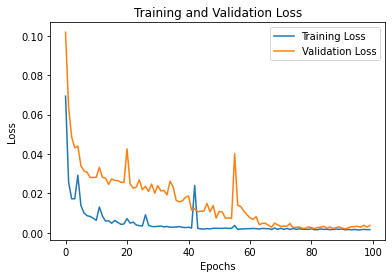

time: 295 ms (started: 2022-06-10 08:48:14 +00:00)


In [ ]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['loss'], label = 'Training Loss')
plt.plot(n, autoencoder_train.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
pred = autoencoder.predict(source_test)

time: 5.37 s (started: 2022-06-10 09:28:49 +00:00)


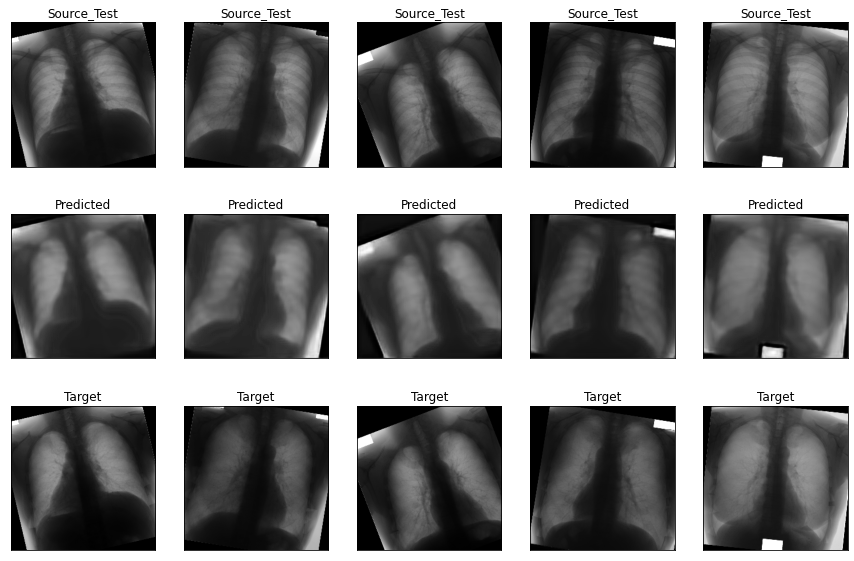

time: 1.01 s (started: 2022-06-10 09:28:57 +00:00)


In [ ]:
plt.figure(figsize=(15,10))

for i in range(5):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(source_test[i].reshape(256,256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source_Test')

    ax = plt.subplot(3, 5, i+6)
    plt.imshow(pred[i].reshape(256,256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Predicted')
    
    ax = plt.subplot(3, 5, i+11)
    plt.imshow(target_test[i].reshape(256,256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()